In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import QED
import random
from rdkit import Chem
from rdkit.Chem import rdchem
from rdkit import Chem
from rdkit.Chem import QED, AllChem, DataStructs

c:\Users\26070\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

## Environment

Environment: A molecular environment where SMILES strings are modified based on actions.

In [3]:
# Define the molecular environment
class MolecularEnvironment:
    def __init__(self, max_steps=50):
        self.max_steps = max_steps
        self.reset()

    # def reset(self):
    #     """Reset the environment by initializing a random molecule."""
    #     self.current_smiles = "C"  # Start with methane
    #     self.steps = 0
    #     return self.current_smiles
    def reset(self):
        """Initialize with a random starting molecule."""
        possible_starts = ["C", "CC", "N", "O", "CO", "CCO", "CCN"]  # Varying initial molecules
        self.current_smiles = random.choice(possible_starts)
        self.steps = 0

        self.generated_molecules = []  # Reset molecule history each episode
        return self.current_smiles

    def step(self, action):
        """Take an action (add/remove atoms/bonds) and return the new state, reward, and done."""
        new_smiles = self._apply_action(self.current_smiles, action)
        self.steps += 1
        done = self.steps >= self.max_steps

        if new_smiles is None or not self._is_valid(new_smiles):
            reward = -1.0  # Penalize invalid molecules
            new_smiles = self.current_smiles  # Revert to the previous state
        else:
            reward = self._compute_reward(new_smiles)
            self.current_smiles = new_smiles

        return new_smiles, reward, done

    def _apply_action(self, smiles, action):
        """Modify the molecule based on the action (simplified here)."""
        mol = Chem.MolFromSmiles(smiles)
        if not mol:
            return None
        
        # Convert to editable molecule
        editable_mol = Chem.RWMol(mol)

        # Example: Randomly add an atom (carbon or oxygen)
        if action == 0:  # Add carbon
            smiles += "C"
        elif action == 1:  # Add oxygen
            smiles += "O"
        elif action == 2:  # Add a nitrogen (N)
            editable_mol = self._add_atom(editable_mol, rdchem.Atom("N"))

        elif action == 3:  # Add a fluorine (F)
                editable_mol = self._add_atom(editable_mol, rdchem.Atom("F"))
                
        new_smiles = Chem.MolToSmiles(editable_mol)
        return new_smiles if self._is_valid(new_smiles) else smiles  # Ensure validity

    def _is_valid(self, smiles):
        """Check if a SMILES string is valid."""
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None

    # def _compute_reward(self, smiles):
    #     """Compute the reward for a molecule (e.g., QED score)."""
    #     mol = Chem.MolFromSmiles(smiles)
    #     if mol is None:
    #         return -1.0
    #     qed_score = QED.qed(mol)  # Reward based on QED score
    #     return qed_score

    def _compute_tanimoto(self, smiles1, smiles2):
        """Compute Tanimoto similarity between two molecules."""
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
    
        if mol1 is None or mol2 is None:
            return 0  # Return 0 if invalid molecules

        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius=2, nBits=2048)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius=2, nBits=2048)
    
        return DataStructs.TanimotoSimilarity(fp1, fp2)

    def _compute_reward(self, smiles):
        """Reward function that encourages diverse, drug-like molecules."""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return -1.0  # Penalize invalid molecules

        # QED Score (Drug-likeness)
        qed_score = QED.qed(mol)

        # Diversity penalty
        diversity_penalty = 0
        for existing_smiles in self.generated_molecules:
            tanimoto = self._compute_tanimoto(existing_smiles, smiles)
            if tanimoto > 0.95:  # If too similar to existing ones, penalize
                diversity_penalty -= 0.5

        # Store the new molecule to track diversity
        self.generated_molecules.append(smiles)

        return qed_score + diversity_penalty

    
    def _add_atom(self, mol, atom):
        """Add a new atom and connect it to a random existing atom."""
        editable_mol = Chem.RWMol(mol)
        num_atoms = mol.GetNumAtoms()
    
        if num_atoms == 0:
            return editable_mol  # Cannot add to an empty molecule

        new_idx = editable_mol.AddAtom(atom)  # Add new atom
        random_idx = random.randint(0, num_atoms - 1)  # Pick random existing atom

        editable_mol.AddBond(new_idx, random_idx, Chem.rdchem.BondType.SINGLE)  # Create bond
        return editable_mol


## PPO agent

Policy Network: A neural network to choose actions. The policy network is a neural network that outputs a probability distribution over possible actions given an input state.  
PPO Agent: Implements Proximal Policy Optimization to train the agent. The PPOAgent manages the policy, selects actions, and updates the model using Proximal Policy Optimization (PPO).

In [4]:
# Define the RL policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            # input_dim: The size of the input state (e.g., molecule representation, SMILES length).
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            # action_dim: The number of possible actions (e.g., adding an atom or modifying a molecule).
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)
    
# Define the PPO agent
class PPOAgent:
    def __init__(self, input_dim, action_dim, lr=1e-3):
        self.policy = PolicyNetwork(input_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = 0.99
        self.eps_clip = 0.2

    def select_action(self, state):
        # Converts the state into a tensor.
        state = torch.tensor(state, dtype=torch.float32)
        # Gets action probabilities from the policy network.
        probs = self.policy(state)
        # Samples an action based on these probabilities.
        action = torch.multinomial(probs, 1).item()
        # Outputs the selected action and its probability.
        return action, probs[action].item()

    def train(self, states, actions, rewards, old_probs):
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        old_probs = torch.tensor(old_probs, dtype=torch.float32)

        # Compute discounted rewards
        discounted_rewards = []
        cumulative_reward = 0
        for r in reversed(rewards):
            cumulative_reward = r + self.gamma * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)
        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)
        # This ensures future rewards are less important than immediate rewards.

        # PPO update
        for _ in range(10):  # Perform multiple epochs
            # Get the latest action probabilities.
            probs = self.policy(states)
            # Extract the probabilities of the chosen actions.
            action_probs = probs.gather(1, actions.unsqueeze(1)).squeeze()

            # This calculates how much the new policy deviates from the old one.
            ratios = action_probs / old_probs
            # Measures how much better an action is compared to the average.
            advantages = discounted_rewards - discounted_rewards.mean()

            # Clipping prevents the policy from changing too much.
            # The minimum of surr1 and surr2 is taken to ensure stability.
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages

            loss = -torch.min(surr1, surr2).mean()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()


## Main training loop

Reward Function: Based on QED scores of molecules.  
QED (Quantitative Estimate of Drug-likeness) is a metric used to evaluate how "drug-like" a molecule is based on various physicochemical properties.   
The QED score is derived from eight molecular properties that are associated with drug-likeness:

1. Molecular Weight (MW): Ideal drug molecules often have a molecular weight between 200 and 500 g/mol.
2. LogP (Partition Coefficient): Measures lipophilicity (how well the molecule dissolves in fats). A good range is typically -2 to 5.
3. Hydrogen Bond Donors (HBD): The number of hydrogen bond donors (e.g., -OH or -NH groups).
4. Hydrogen Bond Acceptors (HBA): The number of hydrogen bond acceptors (e.g., oxygen or nitrogen atoms).
5. Polar Surface Area (PSA): Represents the surface area contributed by polar atoms. A low PSA is generally favorable for cell permeability.
6. Number of Rotatable Bonds: Fewer rotatable bonds generally lead to better oral bioavailability.
7. Aromatic Ring Count: Determines the number of aromatic rings in the molecule.
8. Structural Alerts: Checks for certain substructures known to cause toxicity or metabolic instability.

Range: The score is a normalized value between 0 and 1.
0: Least drug-like (undesirable properties for drug development).
1: Highly drug-like (ideal for drug development).

In [5]:
# Main training loop
def train_molecule_generator():
    env = MolecularEnvironment()
    agent = PPOAgent(input_dim=1, action_dim=4)  # number of actions

    num_episodes = 1000
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_rewards = []

        states, actions, rewards, old_probs = [], [], [], []

        while not done:
            action, action_prob = agent.select_action([len(state)])
            new_state, reward, done = env.step(action)

            states.append([len(state)])
            actions.append(action)
            rewards.append(reward)
            old_probs.append(action_prob)

            state = new_state

        agent.train(states, actions, rewards, old_probs)

        print(f"Episode {episode + 1}: Total Reward = {sum(rewards):.2f}")

    return agent  # Return the trained agent


if __name__ == "__main__":
    agent = train_molecule_generator()

Episode 1: Total Reward = -49.36
Episode 2: Total Reward = -133.99
Episode 3: Total Reward = -50.74
Episode 4: Total Reward = -39.04
Episode 5: Total Reward = -55.03
Episode 6: Total Reward = -74.20
Episode 7: Total Reward = -152.51
Episode 8: Total Reward = -160.92
Episode 9: Total Reward = -45.69
Episode 10: Total Reward = -206.39
Episode 11: Total Reward = -76.15
Episode 12: Total Reward = -141.68
Episode 13: Total Reward = -139.98
Episode 14: Total Reward = -47.44
Episode 15: Total Reward = -80.57
Episode 16: Total Reward = -174.45
Episode 17: Total Reward = -104.12
Episode 18: Total Reward = -90.34
Episode 19: Total Reward = -56.19
Episode 20: Total Reward = -226.54
Episode 21: Total Reward = -90.47
Episode 22: Total Reward = -115.63
Episode 23: Total Reward = -128.71
Episode 24: Total Reward = -212.16
Episode 25: Total Reward = -179.27
Episode 26: Total Reward = -277.33
Episode 27: Total Reward = -207.25
Episode 28: Total Reward = -200.12
Episode 29: Total Reward = -128.67
Episod

## Save the model

In [6]:
# Save the policy network and optimizer
def save_agent(agent, filename="ppo_agent.pth"):
    checkpoint = {
        "policy_state_dict": agent.policy.state_dict(),  # Save policy network weights
        "optimizer_state_dict": agent.optimizer.state_dict(),  # Save optimizer state
        "gamma": agent.gamma,  # Save hyperparameters
        "eps_clip": agent.eps_clip
    }
    torch.save(checkpoint, filename)
    print(f"Agent saved to {filename}")

# After training, save the agent
save_agent(agent)

Agent saved to ppo_agent.pth


## Load the model

In [7]:
def load_agent(filename="ppo_agent.pth", input_dim=1, action_dim=4, lr=1e-3):
    checkpoint = torch.load(filename)

    agent = PPOAgent(input_dim, action_dim, lr=lr)  # Reinitialize the agent
    agent.policy.load_state_dict(checkpoint["policy_state_dict"])
    agent.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    agent.gamma = checkpoint["gamma"]
    agent.eps_clip = checkpoint["eps_clip"]

    print(f"Agent loaded from {filename}")
    return agent

# Load the trained agent for inference
agent = load_agent()

Agent loaded from ppo_agent.pth


## Generate and visualize New Molecules

In [8]:
def generate_new_molecules(agent, num_molecules=10, max_steps=50):
    env = MolecularEnvironment(max_steps=max_steps)  # Same environment used during training
    generated_molecules = []

    for _ in range(num_molecules):
        state = env.reset()  # Start with the initial molecule (e.g., "C")
        molecule_steps = [state]  # Track the molecule's evolution
        done = False

        while not done:
            # Convert state to input for the policy network
            state_input = torch.tensor([len(state)], dtype=torch.float32)

            # Get action probabilities from the trained policy network
            with torch.no_grad():  # Disable gradient calculation for inference
                action_probs = agent.policy(state_input)

            # Select the action with the highest probability (greedy action)
            action = torch.argmax(action_probs).item()

            # Step through the environment
            new_state, _, done = env.step(action)

            molecule_steps.append(new_state)  # Track the molecule's evolution
            state = new_state

        # Add the final molecule to the results
        generated_molecules.append(molecule_steps[-1])

    return generated_molecules


In [11]:
# Generate 4 new molecules
new_molecules = generate_new_molecules(agent, num_molecules=4)

# Print the generated molecules
for idx, molecule in enumerate(new_molecules):
    print(f"Molecule {idx + 1}: {molecule}")


Molecule 1: NNNNN(N(N)NNN)C(N(N)N(N)N)(N(NNN)N(N)N(N)N(NN)NN)N(N(N)N)N(N)NN
Molecule 2: NNNN(N(N)N)N(ON(N)N(N)N(NNNNN(N)N)N(N)N)N(NNN)N(NN)NN
Molecule 3: NNNN(NN)N(N(NN)NNN)N(NN)N(N)N(N)N(N(N)N)N(NN(N)N)N(N)NN
Molecule 4: NNNNN(N)N(N)N(NNNN)C(NNN)(ON(N(NN)NNN)N(N(N)NN)N(N)N(N)NN)N(N)NN


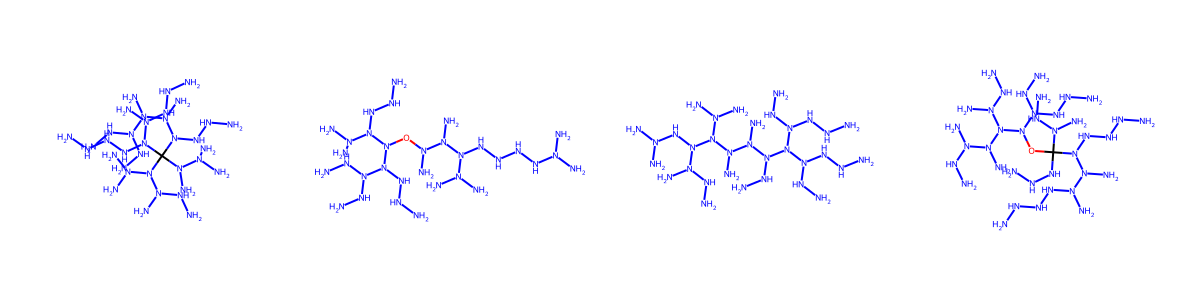

In [12]:
from IPython.display import display
from rdkit import Chem
from rdkit.Chem import Draw

# Convert SMILES to RDKit molecules
mols = [Chem.MolFromSmiles(smiles) for smiles in new_molecules if Chem.MolFromSmiles(smiles)]

# Generate the image
img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300, 300))

# Display in Jupyter Notebook
display(img)